# Continuous Control

---


### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ../python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
from workspace_utils import active_session
import random
import torch
import numpy as np
import datetime
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from ddpg_agent import Agent, ReplayBuffer

In [3]:
# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
n_agents = len(env_info.agents)
seed = 5
# initialize agents
agent = Agent(state_size=brain.vector_observation_space_size, 
                action_size=brain.vector_action_space_size, 
                random_seed=seed,
                num_agents=n_agents)

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   7.90150833e+00  -1.00000000e+00
   1.25147629e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -5.22214413e-01]


# DDPG

Start Time: 2020-09-03 01:14:24.894096
Episode 100	Average Score: 19.95	Score: 36.76
Episode 200	Average Score: 33.51	Score: 34.46
Episode 300	Average Score: 33.53	Score: 34.71
Episode 400	Average Score: 33.66	Score: 29.59
Episode 500	Average Score: 32.87	Score: 30.55
Episode 600	Average Score: 33.44	Score: 34.58
Episode 700	Average Score: 33.22	Score: 35.16
Episode 800	Average Score: 33.75	Score: 31.11
Episode 900	Average Score: 32.10	Score: 31.52
Episode 1000	Average Score: 32.89	Score: 33.12


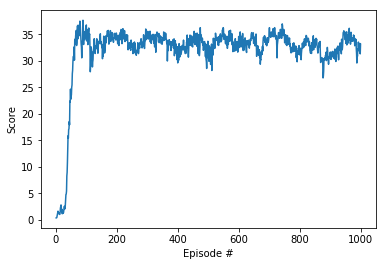

End Time: 2020-09-03 08:37:33.756644


In [7]:
with active_session():
    def ddpg(n_episodes=1000, max_t=1000):
        scores_deque = deque(maxlen=100)
        scores_mean = []
        max_score = -np.Inf
        UPDATE_FREQ = 2
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]  
            states = env_info.vector_observations                  # get the current state (for each agent)
            scores = np.zeros(num_agents) 
            agent.reset()
            for t in range(max_t):
                actions = agent.act(states)
                env_info = env.step(actions)[brain_name]           # send all actions to tne environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if episode finished
                scores += env_info.rewards                         # update the score (for each agent) 
                if t % UPDATE_FREQ == 0:
                    update = True
                agent.step(states, actions, rewards, next_states, dones, update)
                update = False
                states = next_states 
                if np.any(dones):
                    break 
            scores_deque.append(np.mean(scores))
            scores_mean.append(np.mean(scores))
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, 
                                                                              np.mean(scores_deque), 
                                                                              np.mean(scores)), end="")
            if i_episode % 100 == 0:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        return scores_mean
    print('Start Time: {}'.format(str(datetime.datetime.now())))
    scores_mean = ddpg()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores_mean)+1), scores_mean)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    print('End Time: {}'.format(str(datetime.datetime.now())))

### 3. Reference: Take Random Actions in the Environment

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [8]:
# env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [9]:
env.close()